In [1]:
import glob
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import pysam
import time
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from bam_barcodes_function import extract_barcode_info

In [3]:
BAM = "../data/raw/14515X1.MT.bam"
BARCODES = "../data/raw/Human2_002_Barcodes.txt"
NUM_CORES = 32
OUT_DIR = "../data/scBam/"
BARCODE_INFO = "../data/scBam/barcode_data.p"

In [4]:
extract_barcode_info(BAM, BARCODE_INFO)

122606514it [27:02, 75546.92it/s]


(defaultdict(int,
             {'CCTTTATCCTATTCAG': 18,
              'TACGAGGAGTCATGCC': 3,
              'GTTATGATGTCTGTGT': 1,
              'TCATTTCATCACGTAA': 3,
              'AGACGTTCCGATCTAG': 245,
              'TGGCGTGGCACCAGAT': 8,
              'CAGTAACCGCTTTTTT': 4,
              'AGCCGTCAACGATCTG': 40,
              'GACTAGCAAGACACGG': 5,
              'TGTCCAGTCTTGATGC': 3,
              'GTCTCGTGTCGAAATA': 8,
              'GATGCGAGGGCTCTCA': 4,
              'TGTTCCCATTGTGCAG': 12,
              'ACGAGTCAGTTCATGA': 5,
              'TGGTTCCAAGCTGTTA': 30,
              'TTGTCAAGAGGTTATA': 1,
              'GTCACGGTGGTCCGTG': 3,
              'TCATTACATCTCCCAT': 12,
              'GGAACCTATCTCGATG': 5,
              'GCTGGTGTCTAGCCGC': 8,
              'TGAGGAAGACAGGCTT': 7,
              'CGACCTTCAAGCGCTG': 1,
              'GTCATTTCTAAGCCAT': 6,
              'GTGGTCCAAGGGTCAT': 11,
              'AAACCTGAGATGCGAC': 2003,
              'AAACGGGAGGGTGTGT': 2432,
      

In [5]:
[CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs] = pickle.load(open(BARCODE_INFO,"rb"))

## Get info from BAM files

In [3]:
samfile = pysam.AlignmentFile(BAM, "rb")
bam_dict = dict()
barcodes = set()
corrected_barcodes = set()
barcode_pairs = set()
CR_read_number = defaultdict(int)
CB_read_number = defaultdict(int)
BC_read_number = defaultdict(int)

for read in tqdm(samfile.fetch('MT')):
    d = dict(read.tags)
    if "CR" in d:
        barcodes.add(d["CR"])
        CR_read_number[d["CR"]] += 1
        if "CB" in d:
            CB = d["CB"].split('-')[0]
            barcode_pairs.add((CB, d["CR"]))
            corrected_barcodes.add(CB)
            CB_read_number[CB] += 1
        else:
            barcode_pairs.add(('-', d["CR"]))
    else:
        if "CB" in d:
            CB = d["CB"].split['-'][0]
            pair_barcodes.add((CB, '-'))
            corrected_barcodes.add(CB)
            CB_read_number[CB] += 1
samfile.close()

122606514it [28:26, 71860.15it/s]


## Save files 

In [4]:
pickle.dump([CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs], file=open(BARCODE_INFO, "wb"))

In [5]:
def hamming_distance(pattern1, pattern2):
    '''
    This function calculates the number of mismatches between two patterns ("pattern1" and "pattern2")
    of equal lenght.
    '''
    assert len(pattern1) == len(pattern2)
    return sum(p1 != p2 for p1, p2 in zip(pattern1, pattern2))

In [6]:
print('Number of different barcodes {}'.format(len(barcodes)))
print('Number of corrected barcodes {}'.format(len(corrected_barcodes)))

Number of different barcodes 1899848
Number of corrected barcodes 295614


In [7]:
txt_barcodes = open(BARCODES).read().split('\n')[:-1]

In [8]:
len(txt_barcodes)

670

## Plot distribution of reads per CR

(array([1.899572e+06, 1.920000e+02, 5.200000e+01, 2.700000e+01,
        2.000000e+00, 2.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.000000e+00, 1.354250e+04, 2.708400e+04, 4.062550e+04,
        5.416700e+04, 6.770850e+04, 8.125000e+04, 9.479150e+04,
        1.083330e+05, 1.218745e+05, 1.354160e+05]),
 <a list of 10 Patch objects>)

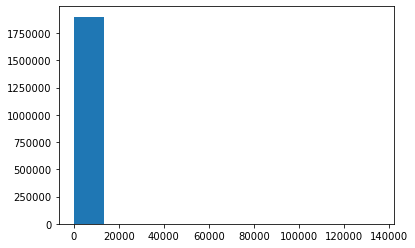

In [9]:
plt.hist(list(CR_read_number.values()))

## Plot distribution of reads per CB

(array([2.95339e+05, 1.92000e+02, 5.10000e+01, 2.70000e+01, 2.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000e+00, 1.39580e+04, 2.79150e+04, 4.18720e+04, 5.58290e+04,
        6.97860e+04, 8.37430e+04, 9.77000e+04, 1.11657e+05, 1.25614e+05,
        1.39571e+05]),
 <a list of 10 Patch objects>)

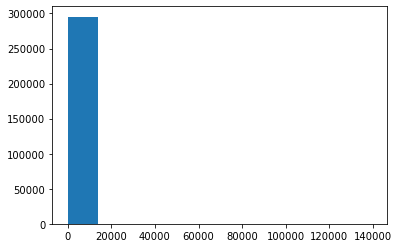

In [10]:
plt.hist(list(CB_read_number.values()))

## Assign CRs

In [11]:
assigned_CR2bc = defaultdict(lambda: defaultdict(set)) # First key is threshold, second is barcode in txt
assigned_CRnumber = defaultdict(lambda: defaultdict(int)) # First key is threshold, second is barcode in CR
thresholds = [1, 3]


for bc in tqdm(txt_barcodes):
    for CR in barcodes:
        for t in thresholds:
            if hamming_distance(bc, CR) <= t:
                assigned_CR2bc[t][bc].add(CR)
                assigned_CRnumber[t][CR] += 1

100%|██████████| 670/670 [1:48:57<00:00,  9.76s/it]


### Count how many CRs were assigned to more than one barcode in txt file

In [12]:
over_one_CR = []
for k, v in assigned_CRnumber[1].items():
    if v > 1:
        over_one_CR.append(k)

In [13]:
len(over_one_CR)

3

In [14]:
len(assigned_CRnumber[1])

2351

In [15]:
len(assigned_CRnumber[3])

67087

## Assign CBs

In [16]:
assigned_CB2bc = defaultdict(lambda: defaultdict(set)) # First key is threshold, second is barcode in txt
assigned_CBnumber = defaultdict(lambda: defaultdict(int)) # First key is threshold, second is barcode in CR
thresholds = [1, 3]
diff_len_CB = set()

for bc in tqdm(txt_barcodes):
    for CB in corrected_barcodes:
        CB = CB.split('-')[0]
        for t in thresholds:
            try:
                if hamming_distance(bc, CB) <= t:
                    assigned_CB2bc[t][bc].add(CB)
                    assigned_CB2number[t][CB] += 1
            except:
                diff_len_CB.add(CB)

100%|██████████| 670/670 [17:39<00:00,  1.58s/it]


In [17]:
len(assigned_BCnumber[1])

NameError: name 'assigned_BCnumber' is not defined

In [ ]:
len(assigned_BCnumber[3])

In [ ]:
len(diff_len_CB)

## Read in data that was saved

In [4]:
[CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs]=pickle.load(open(BARCODE_INFO, "rb"))


In [6]:
count = 0
count = 0
for key in CB_read_number:
    if CB_read_number[key] > 200:
        count += 1
print(count)

75908


In [7]:
count = 0
for key in CR_read_number:
    if CR_read_number[key] > 200:
        count += 1
print(count)

76123


In [9]:
print(len(CR_read_number))
print(len(CB_read_number))

1899848
295614


In [5]:
CR_read_number

defaultdict(int,
            {'CCTTTATCCTATTCAG': 18,
             'TACGAGGAGTCATGCC': 3,
             'GTTATGATGTCTGTGT': 1,
             'TCATTTCATCACGTAA': 3,
             'AGACGTTCCGATCTAG': 245,
             'TGGCGTGGCACCAGAT': 8,
             'CAGTAACCGCTTTTTT': 4,
             'AGCCGTCAACGATCTG': 40,
             'GACTAGCAAGACACGG': 5,
             'TGTCCAGTCTTGATGC': 3,
             'GTCTCGTGTCGAAATA': 8,
             'GATGCGAGGGCTCTCA': 4,
             'TGTTCCCATTGTGCAG': 12,
             'ACGAGTCAGTTCATGA': 5,
             'TGGTTCCAAGCTGTTA': 30,
             'TTGTCAAGAGGTTATA': 1,
             'GTCACGGTGGTCCGTG': 3,
             'TCATTACATCTCCCAT': 12,
             'GGAACCTATCTCGATG': 5,
             'GCTGGTGTCTAGCCGC': 8,
             'TGAGGAAGACAGGCTT': 7,
             'CGACCTTCAAGCGCTG': 1,
             'GTCATTTCTAAGCCAT': 6,
             'GTGGTCCAAGGGTCAT': 11,
             'AAACCTGAGATGCGAC': 2003,
             'AAACGGGAGGGTGTGT': 2432,
             'AAACGGGCATGGTCTG': 

## Filter for under 200

In [7]:
count = 0
CB_filter = set()
for key in CB_read_number:
    if CB_read_number[key] > 200:
        CB_filter.add(key)
        count += 1
print(count)

75908
